# Interpolate Sticky-Delta Volatility with Python

In OTC FX option market, volatility smiles are quoted in a delta-volatilty instead of strike-volatility convention in equity option market. For pricing a given option, when one prepares volatility as a parameter in a Black-Scholes formula, they need to calculate the volatility for the given strike price in a delta-volatility dimension matrix.

## 1. Quoted in Delta (premium excluded)
Premium excluded delta is the case where the premium is paid in the quoted currency (ccy2) of a currency pair, for example EUR/USD. Here the deltas can be used for interpolation without any adjustment.

First, setup the market data.
You may notice that negative deltas are used, which means they are deltas of put. The reason will be explained in the section for premium included delta.

In [1]:
import QuantLib as ql
import math
import numpy as np
import matplotlib.pyplot as plt

as_of_date = ql.Date(1,2,2022)
# Market Data
tenors = [ql.Period('1M'), ql.Period('3M'), ql.Period('6M')]
maturities = [as_of_date + t for t in tenors]
voltilities = [[0.040, 0.030, 0.020, 0.025, 0.035], 
               [0.045, 0.040, 0.030, 0.035, 0.042],
               [0.060, 0.052, 0.035, 0.045, 0.048],
              ]
deltas = [[-0.90, -0.75, -0.5, -0.25, -0.10], 
          [-0.90, -0.75, -0.5, -0.25, -0.10], 
          [-0.90, -0.75, -0.5, -0.25, -0.10], 
         ]
delta_type = ql.DeltaVolQuote.Spot
rTS = ql.FlatForward(ql.Date(1,2,2022), ql.QuoteHandle(ql.SimpleQuote(0.0)), ql.Actual360(), ql.Compounded, ql.Annual)
qTS = ql.FlatForward(ql.Date(1,2,2022), ql.QuoteHandle(ql.SimpleQuote(0.0)), ql.Actual360(), ql.Compounded, ql.Annual)
spot = 1.1
strike = 1.2

Striky-delta is the quotation form that has delta for x-axis and volatility for y-axis. When we price a option with given strike, we firstly need to convert the strike to delta then map it to volatility. However, the delta formula needs both strike and volatility as inputs.
$${\Delta}_{put}(K,{\sigma}) = {e}^{-(r-q)t}N(-\frac{ln(\frac{S}{K})+(r-q+\frac{{\sigma}^2}{2})t}{{\sigma}\sqrt{t}})$$
Therefore, we need an initial guess of ${\sigma}_{1}$ as input together with ${K}$, and obtain ${\Delta}_{put}$ then interpolate ${\sigma}$ from the ${\Delta}$-${\sigma}$ quotation. Usually ${\sigma}_{ATM}$ is chosen to be the initial guess. The output ${\sigma}_{2}$ will be different from our input ${\sigma}_{1}$, so that we use ${\sigma}_{2}$ as input and repeat the step, until the input ${\sigma}_{n}$ and ouput ${\sigma}_{n+1}$ are close enough.

Let's setup a target function (as a class) for recurrsion. All the parameters are decided in `__init__` except ${\sigma}$ (argument `v0`). For the convertion from ${K}$ to ${\Delta}$, we leverage `BlackDeltaCalculator` class in QuantLib. This class has a method `deltaFromStrike` doing the convertion.

In this `TargetFun` class, $K$ (`strike`) is decided in the initialization stage. After that, in the call stage, we can plug the guess `v0` as ${\sigma}_{i}$ into `TargetFun(v0)` then obtain the difference of ${\sigma}_{i+1}$ and ${\sigma}_{i}$.

In [2]:
class TargetFun:
    def __init__(self, as_of_date, spot, rdf, qdf, strike, maturity, deltas, delta_type, smile, interp):
        self.ref_date = as_of_date
        self.strike = strike
        self.maturity = maturity
        self.spot = spot
        self.rDcf = rdf # discount factor
        self.qDcf = qdf # discount factor
        self.t = ql.Actual365Fixed().yearFraction(as_of_date, self.maturity)
        self.interp = interp(deltas, smile)
        self.delta_type = delta_type
        
    def __call__(self, v0):
        optionType = ql.Option.Put
        stdDev = math.sqrt(self.t) * v0
        calc = ql.BlackDeltaCalculator(optionType, self.delta_type, self.spot, self.rDcf, self.qDcf, stdDev)
        d = calc.deltaFromStrike(self.strike)
        v = self.interp(d, allowExtrapolation=True)
        return (v - v0)

Choose a solver in QuantLib.

In [3]:
solver = ql.Brent()
accuracy = 1e-16
step = 1e-12

So far we have prepared the `TargetFun` and all the market data, now all we need to do is to give a $K$ and solve the `TargetFun`.

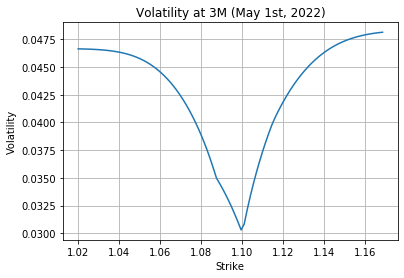

In [4]:
vol_vs_strike = []
strikes = np.linspace(1.02, 1.17, 100, endpoint=False)
display_maturity = as_of_date + ql.Period('3M')

for k in strikes:
    vol_pts = []
    for i, smile in enumerate(voltilities):
        mat = maturities[i]
        target = TargetFun(as_of_date, 
                           spot,
                           rTS.discount(mat), 
                           qTS.discount(mat), 
                           k, 
                           maturities[i], 
                           deltas[i], 
                           delta_type, 
                           smile, 
                           ql.LinearInterpolation) # usually use cubic spline (ql.CubicNaturalSpline)
        guess = smile[2]
        vol_pts.append(solver.solve(target, accuracy, guess, step))

    vts = ql.BlackVarianceCurve(as_of_date, 
                                maturities,
                                vol_pts, 
                                ql.Actual365Fixed(), 
                                False)
    vts.enableExtrapolation()
    vts_handle = ql.BlackVolTermStructureHandle(vts)
    vol_vs_strike.append(vts_handle.blackVol(display_maturity, 1.0))

plt.plot(strikes, vol_vs_strike)
plt.xlabel('Strike')
plt.ylabel('Volatility')
plt.title(f'Volatility at 3M ({display_maturity})')
plt.grid(True)
plt.show()

(1.02, 4.664327688939244)
(1.0215, 4.663742127059701)
(1.023, 4.663025777420972)
(1.0245, 4.662153559551893)
(1.026, 4.661096589567777)
(1.0275, 4.65982183123114)
(1.029, 4.658291763931581)
(1.0305, 4.656464079411353)
(1.032, 4.654291419757321)
(1.0335, 4.651721169227866)
(1.035, 4.648695311735993)
(1.0365, 4.645150364163889)
(1.038, 4.641017393103521)
(1.0395, 4.636222119154516)
(1.041, 4.630685108715083)
(1.0425, 4.624322048519056)
(1.044, 4.6170440933254735)
(1.0455, 4.6087582725230245)
(1.047, 4.59936793733782)
(1.0485, 4.5887732271489075)
(1.05, 4.576871531350448)
(1.0515, 4.563557922357436)
(1.053, 4.548725535701637)
(1.0545, 4.532265874541195)
(1.056, 4.514069018038038)
(1.0575, 4.494023715592503)
(1.059, 4.472017351479991)
(1.0605, 4.44793576662323)
(1.062, 4.421662925693854)
(1.0635, 4.393080418141144)
(1.065, 4.362066780796795)
(1.0665, 4.32849662711453)
(1.068, 4.292239563554081)
(1.0695, 4.253158866711061)
(1.071, 4.211109884964745)
(1.0725, 4.165938114840138)
(1.074, 4.117

In [6]:
tt = ql.Actual365Fixed().yearFraction(as_of_date, display_maturity)
atm_strike = spot * math.exp(0.5 * tt * 0.030**2)
print(atm_strike)
(1.1001206, 3.00000517338695)
(1.1001208, 3.0000092048927502)

1.10012070525227


(1.1001208, 3.0000092048927502)

In [7]:
vol_pts = []
k = atm_strike
for i, smile in enumerate(voltilities):
    mat = maturities[i]
    target = TargetFun(as_of_date, 
                       spot,
                       rTS.discount(mat), 
                       qTS.discount(mat), 
                       k, 
                       maturities[i], 
                       deltas[i], 
                       delta_type, 
                       smile)
    guess = smile[2]
    vol_pts.append(solver.solve(target, accuracy, guess, step))

vts = ql.BlackVarianceCurve(as_of_date, 
                            maturities,
                            vol_pts, 
                            ql.Actual365Fixed(), 
                            False)
vts.enableExtrapolation()
vts_handle = ql.BlackVolTermStructureHandle(vts)
vol_atm_strike = vts_handle.blackVol(display_maturity, 1.0)
print(vol_atm_strike)

TypeError: __init__() missing 1 required positional argument: 'interp'